In [1]:
"""
Learning to solve parametric Quadratic Programming
portfolio optimization
problems using Neuromancer.

Problem formulation:
    minimize    - p^T x + lambda x^T Q x
    subject to       1^T x = 1
                      x >= 0

Where p is interpreted as a vector of asset returns, and Q represents
the covariance between assets, which forms a penalty on overall
covariance (risk) weighted by lambda.
"""

'\nLearning to solve parametric Quadratic Programming\nportfolio optimization\nproblems using Neuromancer.\n\nProblem formulation:\n    minimize    - p^T x + lambda x^T Q x\n    subject to       1^T x = 1\n                      x >= 0\n\nWhere p is interpreted as a vector of asset returns, and Q represents\nthe covariance between assets, which forms a penalty on overall\ncovariance (risk) weighted by lambda.\n'

In [2]:

import cvxpy as cp
import numpy as np
import time
import torch
import torch.nn as nn
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

from portfolio_utils import gen_portfolio_lto_data, cvx_qp
import cvxpy as cp
from cvxpylayers.torch.cvxpylayer import CvxpyLayer


In [3]:

""
"""
# # #  Dataset
"""
data_seed = 408
np.random.seed(data_seed)
batsize = 100
n_dim = 100
n_train = 5000
n_valid = 100
n_test = 100

budget = 10 #This controls the equality constraint LHS, i.e. sum(x) = budget, have increased, to scale up variable values at higher dimension

#nsim = 100  # number of datapoints: increase sample density for more robust results

# create dictionaries with sampled datapoints with uniform distribution
#data_loaded = np.load('portfolio_data/portfolio_var50_ineq50_eq1_ex12000.npz', allow_pickle=True)
data_loaded = gen_portfolio_lto_data(n_dim,n_train,n_valid,n_test)
Q_load = data_loaded['Q']
A_load = data_loaded['A']
G_load = data_loaded['G']
h_load = data_loaded['h']
x_load = data_loaded['x']
p_train = data_loaded['trainX']
p_valid = data_loaded['validX']
p_test  = data_loaded['testX']
sols_train = data_loaded['trainY']
sols_valid = data_loaded['validY']
sols_test  = data_loaded['testY']
#feat_size_load = data_loaded['feat_size']

print("p_train.dtype")
print( p_train.dtype )

samples_train = {"p": torch.Tensor(p_train)}  # JK TODO fix this, reduced size for debugging
samples_dev   = {"p": torch.Tensor(p_valid)}
samples_test  = {"p": torch.Tensor(p_test )}

# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data   = DictDataset(samples_dev,   name='dev')
test_data  = DictDataset(samples_test,  name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batsize, num_workers=0,
                                            collate_fn=train_data.collate_fn, shuffle=True)
dev_loader   = torch.utils.data.DataLoader(dev_data, batch_size=batsize, num_workers=0,
                                            collate_fn=dev_data.collate_fn, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batsize, num_workers=0,
                                            collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle



Generating dataset . . . 
Training set generated 
Validation set generated 
Test set generated 
p_train.dtype
float64


In [4]:

""

"""
# # #  pQP primal solution map architecture
"""
# define neural architecture for the solution map
func = blocks.MLP(insize=n_dim, outsize=n_dim,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[n_dim*2] * 4)
# define symbolic solution map with concatenated features (problem parameters)
#xi = lambda p1, p2: torch.cat([p1, p2], dim=-1)
#features = Node(xi, ['p1', 'p2'], ['xi'], name='features')
sol_map = Node(func, ['p'], ['x'], name='map')
# trainable components of the problem solution
components = [sol_map]




"""
# # # objective and constraints formulation in Neuromancer
"""
# variables
x = variable("x")

# sampled parameters
p = variable('p')
Q = torch.Tensor(Q_load)

# objective function
lambd = 1.0
f = torch.sum(-p*x, dim = 1) + torch.sum( x*torch.matmul(Q,x.T).T, dim=1 ) #-p@x + lambd * x@Q@x
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]

# constraints
e = torch.ones(n_dim)
Q_con = 100.
con_1 = Q_con*(torch.sum(x, dim=1) == budget) #Q_con*(e@x == 1)
con_1.name = 'c1'
con_2 = Q_con * (x >= 0)
con_2.name = 'c2'

constraints = [con_1, con_2]


"""
# # #  problem formulation in Neuromancer
"""
# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)



In [5]:





"""
# # #  problem solution in Neuromancer
"""
optimizer = torch.optim.AdamW(problem.parameters(), lr=1e-3)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=500,
    patience=100,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)

# Train solution map
best_model = trainer.train()




/Users/king339/Projects/DAIDIST/neuromancer/src/neuromancer/constraint.py:160: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


epoch: 0  train_loss: 197.3984375
epoch: 1  train_loss: 30.383684158325195
epoch: 2  train_loss: 37.46810531616211
epoch: 3  train_loss: 18.76982879638672
epoch: 4  train_loss: 17.173463821411133
epoch: 5  train_loss: 32.20780944824219
epoch: 6  train_loss: 21.89911460876465
epoch: 7  train_loss: 22.217212677001953
epoch: 8  train_loss: 16.190095901489258
epoch: 9  train_loss: 14.212964057922363
epoch: 10  train_loss: 13.666753768920898
epoch: 11  train_loss: 14.784401893615723
epoch: 12  train_loss: 15.307765007019043
epoch: 13  train_loss: 13.229848861694336
epoch: 14  train_loss: 13.601710319519043
epoch: 15  train_loss: 19.14226722717285
epoch: 16  train_loss: 12.478659629821777
epoch: 17  train_loss: 19.15145492553711
epoch: 18  train_loss: 20.35680389404297
epoch: 19  train_loss: 14.932421684265137
epoch: 20  train_loss: 14.34903335571289
epoch: 21  train_loss: 17.294435501098633
epoch: 22  train_loss: 18.13784408569336
epoch: 23  train_loss: 11.81821060180664
epoch: 24  train_lo

In [6]:


'''
#######################################
#######################################

Add on a DR correction layer

#######################################
########################################
'''


import DRSolver as dr
from importlib import reload

reload(dr)


'''
# DEFINE THE OBJECTIVE
'''
# x is assumed to include slack variables!
def f_obj(x,p):
    x = x[:n_dim]
    return -p@x + lambd * x@(Q@x)            #lambd * torch.sum(x*torch.mv(Q,x))   #torch.sum( -p*x  ) +          #-p@x + lambd * x@(Q@x)


'''
# DEFINE THE CONSTRAINTS
'''
def F_ineq(x,p):
    x = x[:n_dim]
    return -x

def F_eq(x,p):
    x = x[:n_dim]
    return (x.sum() - budget).unsqueeze(0)


num_steps = 10 # number of DR iterations to take
initial_steps = 0
x_dim = n_dim # dimension of primal variable
n_ineq = n_dim #number of inequality constraints
n_eq = 1 #number of equality constraints
parm_dim = n_dim #number of problem parameters
order = 'second' # What order approximation of the objective to use {'first', 'second'}
project_fixedpt = False
#metric scaling parameters
initial_lb_P = 1e-1
initial_ub_P = 1e1
#initial_lb_P = 1/2
#initial_ub_P = 2
lb_P = 1.0/50.0
ub_P = 50.0
scl_lb_P = 0.05
scl_ub_P = 0.7
#lb_P = 1.0/100.0
#ub_P = 1.0
#scl_lb_P = 0.01
#scl_ub_P = 10.0
solver = dr.DRSolver(
    f_obj = f_obj, 
    F_ineq = F_ineq,
    F_eq = F_eq,
    x_dim = x_dim, 
    n_ineq = n_ineq,
    n_eq = n_eq, 
    order = order,
    JF_fixed=True,
    parm_dim = parm_dim,
    num_steps = num_steps,
    initial_steps= initial_steps,
    initial_lb_P=initial_lb_P,
    initial_ub_P = initial_ub_P,
    lb_P = lb_P,
    ub_P = ub_P,
    scl_lb_P = scl_lb_P,
    scl_ub_P = scl_ub_P,
    project_fixedpt=project_fixedpt
    )



# REMAP THROUGH DR CORRECTION
sol_map = Node(func, ['p'], ['x_predicted'], name='map')
DR_correction = Node(solver,['x_predicted','p'],['x','cnv_gap'])
components = [sol_map, DR_correction]



### ADD A CONVERGENCE PENALTY
cnv_gap = variable("cnv_gap")
f_cnv = (cnv_gap)**2
cnv_obj = f_cnv.minimize(weight=1e8, name='cnv_obj')
objectives = [cnv_obj]
constraints = []



# create loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)




In [ ]:

'''
#######################################
#######################################

Train DR correction layer

#######################################
########################################
'''

DR_train_epochs = 40
optimizer = torch.optim.AdamW(solver.parameters(), lr=1e-3)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=DR_train_epochs,
    patience=500,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)

# Train solution map
best_model = trainer.train()


In [ ]:
#torch.save(best_model,'Saved_Models/portfolio500_10steps_budget100_02.pth')

In [7]:
#problem.load_state_dict(torch.load('Saved_Models/large_portfolio_10steps_budget10_02.pth'))

<All keys matched successfully>

In [9]:
import time

t = time.time()
with torch.no_grad():
    samples_test['name'] = 'test'
    model_out = problem(samples_test)
nm_time = time.time() - t


x_nm_test = model_out['test_' + "x"].detach().numpy()
x_loaded_test  = data_loaded['testY']

# print("samples_test['p']")
# print(samples_test['p'])

cvxpy_layer = cvx_qp(n_dim,Q,budget)
t = time.time()
x_cvxpy_test = cvxpy_layer(samples_test['p'])
cv_time = time.time() -t

# print("x_nm_test")
# print( x_nm_test )
# print("x_loaded_test")
# print( x_loaded_test )
# print("x_cvxpy_test")
# print( x_cvxpy_test )


import portfolio_utils as util
from importlib import reload
reload(util)
# Q_load = data_loaded['Q']
# A_load = data_loaded['A']
# G_load = data_loaded['G']
# h_load = data_loaded['h']


# A = np.ones((1, n_dim))
#     h = np.zeros(n_dim)
#     G = -np.eye(n_dim)
#p = np.transpose(p_test)
#p = np.transpose(p_train)
#p = np.transpose(samples_train['p'].detach().numpy())
#cvxpy_sol, time = util.solve_convexqp(Q_load, p, A_load, G_load, h_load, budget, tol=1e-3)


# print('cv/nm time:',cv_time/nm_time)

sol_diff = np.mean(np.sum((x_cvxpy_test.detach().numpy() - x_nm_test)**2,axis=-1))
rel_sol_diff = np.mean(np.sum((x_cvxpy_test.detach().numpy() - x_nm_test)**2,axis=-1)/np.sum(x_cvxpy_test.detach().numpy()**2,axis = -1))
print("Average relative Solution Difference:",np.mean(rel_sol_diff))
print("Average Solution difference: ", np.mean(sol_diff))

#sol_diff = np.mean(np.sum((cvxpy_sol - x_nm_test)**2,axis=-1))
#print("Average Solution difference: ", np.mean(sol_diff))

# '''
# Compute Train set error
# '''


# with torch.no_grad():
#     t = time.time()
#     samples_train['name'] = 'train'
#     model_out = problem(samples_train)
#     nm_time = time.time() - t


# x_nm_test = model_out['train_' + "x"].detach().numpy()
# x_loaded_test  = data_loaded['trainY']


# cvxpy_layer = cvx_qp(n_dim,Q)
# x_cvxpy_test = cvxpy_layer(samples_train['p'])

# # print("x_nm_test")
# # print( x_nm_test )
# # print("x_loaded_test")
# # print( x_loaded_test )
# # print("x_cvxpy_test")
# # print( x_cvxpy_test )

# sol_diff = np.mean(np.sum((x_cvxpy_test.detach().numpy() - x_nm_test)**2,axis=-1))
# print("Average Solution Difference:",np.mean(sol_diff))




Average relative Solution Difference: 2.6684722e-07
Average Solution difference:  4.6465385e-07


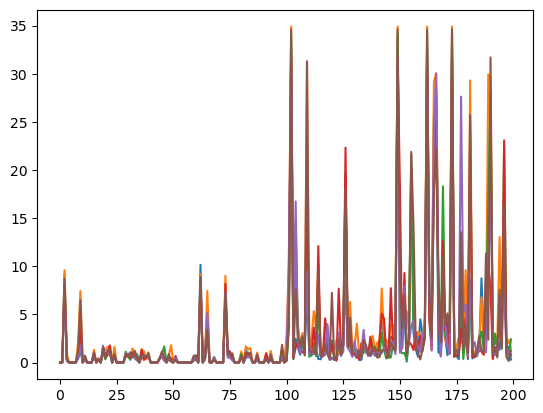

In [10]:


'''
Plot the meterics that are learned
'''


pr = samples_test['p']


j = 32
for j in [1,24,6,18,29,51]:
    a = solver.Pm_2('',pr[j,:])
    plt.plot(np.diag(a.detach().numpy()))


Text(0, 0.5, 'number of problems')

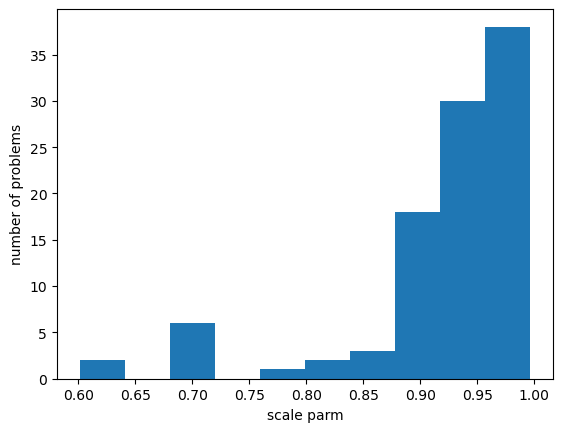

In [11]:

'''
Plot the scaling that is learned.
'''

td = next(iter(train_loader))
scl = torch.sigmoid(solver.Pm_2.ScaleMap(td['p']))
plt.hist(scl.detach().numpy())
plt.xlabel('scale parm')
plt.ylabel('number of problems')

In [12]:

P_v_list = []
for i in range(pr.shape[0]):
    P_vals = solver.Pm_2('',pr[i,:])
    P_v_list.append(torch.diag(P_vals)[n_dim:].detach().numpy())
    
pv = np.stack(P_v_list)

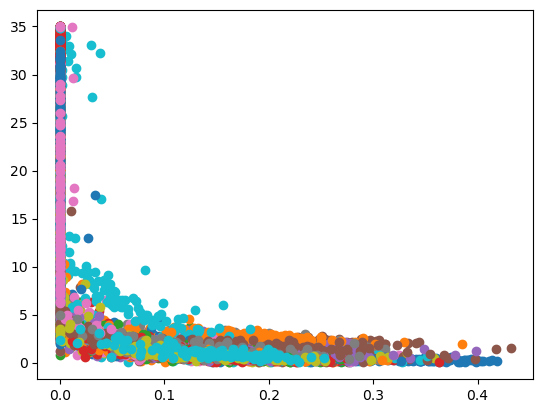

In [13]:
for k in range(n_dim):
    #plt.scatter(x_nm_test[:,k],pv[:,k])
    plt.scatter(x_cvxpy_test.detach().numpy()[:,k],pv[:,k])


In [ ]:
'''
Convergence Evaluation
'''
solver.num_steps = 30

test_p = torch.tensor([ 0.0786, -0.1396,  0.0544,  0.5873, -0.1937,  0.0593,  0.2089, -0.2672,
         0.2413,  0.1833, -0.1695,  0.1558,  0.3340,  0.2615, -0.0777, -0.2420,
        -0.4748, -0.0198,  0.0820, -0.1486],dtype = torch.float32)

test_x = torch.tensor([0.0571, 0.0828, 0.1068, 0.0153, 0.0139, 0.0655, 0.0151, 0.0279, 0.0574,
        0.0053, 0.0264, 0.0175, 0.0355, 0.0876, 0.0247, 0.0498, 0.0314, 0.0840,
        0.0746, 0.1085],dtype = torch.float32)






test_p =torch.tensor([ 1.7857e-01, -2.7497e-01,  2.5717e-01,  3.8364e-02, -7.7331e-04,
        -2.9028e-01,  3.3549e-02, -1.1741e-01, -2.1641e-02, -3.5141e-02,
         7.9165e-02, -5.1123e-01,  4.4745e-01,  3.6999e-01,  3.5046e-02,
         2.5234e-01,  2.3587e-01,  7.4071e-02, -2.3285e-01,  1.9717e-01,
        -9.9756e-02,  1.3691e-01,  1.6738e-01, -2.2785e-01,  4.0373e-02,
         5.2640e-03,  4.6145e-01, -8.4815e-01,  1.6224e-03, -4.8091e-01,
        -1.0678e-01,  1.6898e-01,  3.6447e-01,  4.2021e-01,  1.3222e-01,
        -1.3869e-01,  2.1727e-01, -2.9587e-01,  1.4124e-01,  3.8298e-01,
         1.3537e-01,  4.8293e-01, -3.2068e-01, -2.2352e-01, -2.5423e-01,
         8.5373e-02, -6.7962e-02, -9.7984e-02, -5.3502e-02,  2.7891e-01,
         2.8244e-01, -1.3083e-01,  7.4079e-02, -4.5340e-01, -3.0208e-01,
        -6.0530e-01,  3.0580e-01,  3.5115e-02, -5.4756e-01, -1.1652e-01,
         2.7381e-01,  4.9779e-01,  3.9558e-01,  1.3829e-01, -5.0766e-01,
         1.6634e-01, -2.1521e-02,  3.3210e-01,  1.8912e-02,  2.3219e-02,
        -5.5921e-01, -1.7104e-01, -2.2898e-01, -2.1905e-01, -1.8726e-01,
        -7.9069e-02, -3.5976e-02,  5.2348e-01, -4.7270e-02,  1.5996e-01,
        -3.7088e-01, -1.5538e-01, -2.1970e-01, -8.4674e-02, -9.5221e-02,
         3.5431e-01,  9.1328e-03,  1.5133e-01,  3.2873e-01, -1.3085e-02,
         2.6877e-01, -6.6001e-02, -1.6084e-02,  2.0000e-01, -9.7725e-02,
        -6.0260e-02,  7.6604e-02,  1.1087e-01, -1.0653e-01, -2.5936e-01],dtype = torch.float32)

test_x = torch.tensor([ 2.8652e-02, -1.8720e-02,  4.5943e-03,  2.0666e-02,  5.3052e-02,
         1.0566e-02, -2.3301e-04,  7.4269e-03, -4.0737e-03,  4.0351e-02,
         3.3887e-03, -2.8895e-02, -8.0340e-03,  5.5137e-02,  2.0804e-02,
         5.8592e-03, -9.7132e-05,  4.8359e-02, -3.4225e-02, -2.6139e-02,
         2.7030e-02, -2.8122e-02, -1.9087e-02,  1.0089e-04,  2.0335e-02,
         5.0663e-03, -1.5315e-02, -1.1443e-02,  4.8434e-02, -9.4290e-03,
        -3.4455e-03,  1.2143e-02, -3.3611e-03,  2.4777e-04,  5.6196e-03,
        -1.0082e-02,  6.5460e-02,  7.1221e-05, -2.5061e-02,  5.1259e-02,
         1.0274e-04,  5.6792e-02,  5.8215e-02, -1.1410e-03,  3.6398e-02,
         1.1078e-02,  4.5247e-02,  1.8908e-02,  2.3678e-03,  3.5135e-03,
         4.1801e-02, -4.6820e-03,  6.3582e-04,  1.6950e-02, -1.3386e-02,
         1.8284e-02, -2.0947e-02,  3.6561e-02,  6.6216e-02, -8.3138e-04,
         7.6932e-05, -7.4624e-03, -1.5951e-02,  1.4933e-02, -3.3135e-02,
         1.6421e-02,  4.4886e-02,  4.2690e-02,  4.6706e-03, -6.9701e-03,
        -1.9117e-02, -4.8848e-04, -3.0347e-02,  1.7936e-02, -2.6791e-04,
         5.1786e-02, -6.4215e-04,  3.8023e-03,  4.3435e-02, -7.2335e-03,
         9.9769e-05,  1.1077e-02,  4.4773e-02,  1.0966e-02, -1.7365e-03,
        -9.9912e-03,  8.1190e-03, -2.1046e-04,  4.0432e-02,  1.9598e-02,
        -1.6820e-02, -1.0310e-02,  4.5409e-02,  5.8548e-03, -1.7351e-02,
        -2.0528e-02, -1.2997e-02,  6.0960e-03,  3.6543e-02,  3.6034e-02],dtype = torch.float32)




test_x = torch.unsqueeze(test_x,0)
test_p = torch.unsqueeze(test_p,0)

x_hist = solver(test_x,test_p)[2]
x_hist = torch.stack(x_hist).detach().numpy()
x_hist = x_hist[:,0,0:100]



In [ ]:
#np.save('Convergence_Data/portfolio100_DR.npy',x_hist)

In [ ]:
plt.plot(np.log10(np.sum((x_hist - x_cvxpy_test.detach().numpy())**2,axis = 1)))